<font size = 5> <b> Statistical Data Analysis  </font> </b>


Since we have a lot of features due to different types of facilities located very close to each other, the first test we want to do is to determine if there are strong correlations between pairs of independent variables or between an independent and the dependent variable. 

To perform this test, we calculate the Variation Inflation Factor (VIF). The VIF is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.


We then remove the features that are colinear by taking the average of distances between different facilities that are colinear. 

Next, we plot a heat map between the different predictor variables, and the target variable. We then determine the independent variables that have a high correlation coefficient, a score of above 0.95 or -0.95. This test for multi-colinearity will identify features that are highly correlated with each other. However, one of the assumption of a linear regression model is the indepedent variables should be uncorrelated. Preserving highly correlated variables may result in coefficients from the regression not to be estimated precisely, and the standard errors are likely to be high. 


Next, we perform a Recursive Feature Elimination Method where features are dropped recursively and a model score is calculated at each step. The model with highest score is preserved, and the resulting features are given a rank, where a rank of 1 indicates the feature is important, and any other value indicates that the feature is not important. 

Finally, a lasso regularization method is used where irrelavant features are identified by penalizing it's coefficient to zero. 




In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as plot
import matplotlib
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

from scipy.stats import pearsonr

import time


from scipy.stats import boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


from matplotlib import cm

import matplotlib.lines as mlines

import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

<b> <font size =5> Test 1: Variation Inflation Factor Scores </b> </font>

In [307]:
## Reading input data
BC = pd.read_csv("Data/BC_input.csv")
NO2 = pd.read_csv("Data/NO2_input.csv")

In [308]:
#Convert columns to non-numeric 
BC = BC._get_numeric_data() #drop non-numeric cols
NO2 = NO2._get_numeric_data() #drop non-numeric cols

In [309]:
# Drop first column
BC.drop(BC.columns[0], axis=1, inplace=True)
NO2.drop(NO2.columns[0], axis=1, inplace=True)

### VIF scores for BC

In [310]:
BC.rename(columns = {'BC Value': 'BC_Value'}, inplace = True)

In [311]:
BC.head()

BC_Value  10452911-Retail-Res-high_dist  10457411-Manufacturing-high_dist  \
0  0.818032                       6.386582                          4.092391   
1  0.551475                       6.346233                          4.128451   
2  0.593712                       6.358146                          4.110642   
3  0.489898                       6.333521                          4.145896   
4  0.739341                       6.369023                          4.092496   

   10457511-Manufacturing-high_dist  10457611-Manufacturing-high_dist  \
0                          1.995507                          1.909979   
1                          1.970443                          1.879757   
2                          1.974141                          1.885975   
3                          1.965829                          1.872663   
4                          1.976688                          1.891080   

   10457711-Foundaries-high_dist  10460511-Retail-Res-high_dist  \
0                      10.131771                       3.600953   
1                      10.091528                       3.612502   
2                      10.103376                       3.601578   
3                      10.078866                       3.622568   
4                      10.114173                       3.589663   

   10466511-FoodPlant-high_dist  10469511-Retail-Res-high_dist  \
0                     12.466888                       1.896254   
1                     12.428681                       1.884551   
2                     12.439285                       1.882327   
3                     12.417202                       1.885850   
4                     12.448772                       1.878961   

   10472611-EGen-high_dist  10476711-Manufacturing-high_dist  \
0                 2.672432                          5.177325   
1                 2.657113                          5.144002   
2                 2.656454                          5.151872   
3                 2.656791                          5.135194   
4                 2.654588                          5.158560   

   10477411-Waste-high_dist  10510811-AsphaltPlant-high_dist  \
0                  1.168847                         6.260157   
1                  1.166500                         6.225561   
2                  1.160453                         6.234118   
3                  1.171754                         6.216077   
4                  1.153419                         6.241503   

   10517111-Retail-Res-high_dist  10518911-ConcretePlant-high_dist  \
0                       5.466311                          2.040220   
1                       5.493914                          2.038467   
2                       5.478097                          2.032285   
3                       5.509127                          2.043743   
4                       5.461635                          2.025006   

   10523411-Manufacturing-high_dist  10707511-EGen-high_dist  \
0                          3.814717                 5.577767   
1                          3.849203                 5.602305   
2                          3.831713                 5.587334   
3                          3.866281                 5.616603   
4                          3.813819                 5.571631   

   10708011-Waste-high_dist  10708111-Manufacturing-high_dist  \
0                  9.620051                         11.640505   
1                  9.579673                         11.602024   
2                  9.591607                         11.612790   
3                  9.566930                         11.590391   
4                  9.602495                         11.622449   

   1105111-ConcretePlant-high_dist  1106211-Retail-Res-high_dist  \
0                         5.299064                      2.657371   
1                         5.265629                      2.633065   
2                         5.273559                      2.636431   
3                         5.256761          

<b> <font size = 4> Step 1: Set up a multiple regression model </b> </font>

In [312]:
features = []
for i in range(1, 95):
    features.append("Q" + "(" + "'" + (str(BC.columns[i])) + "'" + ")")

features = ' + '.join(features)
    
# get y and X dataframes based on this regression:
y_BC, X_BC = dmatrices('BC_Value ~' + features, BC, return_type='dataframe')    


<b> <font size = 4> Step 2: Calculate VIFs  </b> </font>

In [313]:
# For each X, calculate VIF and save in dataframe
vif_BC = pd.DataFrame()
vif_BC["VIF Factor"] = [variance_inflation_factor(X_BC.values, i) for i in range(X_BC.shape[1])]
vif_BC["features"] = X_BC.columns

<b> <font size = 4> Step 3: Inspect VIFs  </b> </font>

In [314]:
vif_df_BC = vif_BC.round(1)

In [366]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(vif_df_BC)

      VIF Factor                                features
0   4.976477e+07                               Intercept
1   1.285446e+07      Q('10452911-Retail-Res-high_dist')
2   3.832851e+13   Q('10457411-Manufacturing-high_dist')
3   3.689180e+05   Q('10457511-Manufacturing-high_dist')
4   2.105580e+06   Q('10457611-Manufacturing-high_dist')
5   8.687903e+08      Q('10457711-Foundaries-high_dist')
6   1.007574e+07      Q('10460511-Retail-Res-high_dist')
7   3.837361e+05       Q('10466511-FoodPlant-high_dist')
8   5.388400e+04      Q('10469511-Retail-Res-high_dist')
9   2.500077e+06            Q('10472611-EGen-high_dist')
10  9.675214e+06   Q('10476711-Manufacturing-high_dist')
11  6.820700e+04           Q('10477411-Waste-high_dist')
12  4.386660e+06    Q('10510811-AsphaltPlant-high_dist')
13  1.480838e+11      Q('10517111-Retail-Res-high_dist')
14  1.392862e+05   Q('10518911-ConcretePlant-high_dist')
15  8.293922e+12   Q('10523411-Manufacturing-high_dist')
16  1.125295e+11            Q('

### VIF scores for NO2

In [367]:
NO2.rename(columns = {'NO2 Value': 'NO2_Value'}, inplace = True)

In [368]:
NO2.head()

NO2_Value  10452911-Retail-Res-high_dist  10457511-Manufacturing-high_dist  \
0  17.539762                       6.386582                          1.995507   
1  19.956750                       6.346233                          1.970443   
2  23.967768                       6.358146                          1.974141   
3  18.435184                       6.333521                          1.965829   
4  25.797037                       6.369023                          1.976688   

   10460511-Retail-Res-high_dist  10466511-FoodPlant-high_dist  \
0                       3.600953                     12.466888   
1                       3.612502                     12.428681   
2                       3.601578                     12.439285   
3                       3.622568                     12.417202   
4                       3.589663                     12.448772   

   10497111-Retail-Res-high_dist  10510811-AsphaltPlant-high_dist  \
0                       3.103472                         6.260157   
1                       3.092978                         6.225561   
2                       3.090304                         6.234118   
3                       3.094656                         6.216077   
4                       3.086423                         6.241503   

   10517111-Retail-Res-high_dist  10523411-Manufacturing-high_dist  \
0                       5.466311                          3.814717   
1                       5.493914                          3.849203   
2                       5.478097                          3.831713   
3                       5.509127                          3.866281   
4                       5.461635                          3.813819   

   10707511-EGen-high_dist  10708011-Waste-high_dist  \
0                 5.577767                  9.620051   
1                 5.602305                  9.579673   
2                 5.587334                  9.591607   
3                 5.616603                  9.566930   
4                 5.571631                  9.602495   

   127511-Retail-Res-high_dist  136511-EGen-high_dist  \
0                     2.899289               2.203323   
1                     2.883366               2.164149   
2                     2.882973               2.175306   
3                     2.882767               2.152221   
4                     2.881363               2.185464   

   137211-Retail-Res-high_dist  13750711-Retail-Res-high_dist  \
0                     3.713334                       7.107799   
1                     3.711732                       7.063929   
2                     3.705548                       7.078338   
3                     3.716939                       7.048863   
4                     3.698202                       7.091869   

   13760911-Retail-Res-high_dist  13761011-Retail-Res-high_dist  \
0                      12.902228                       2.248262   
1                      12.867530                       2.261906   
2                      12.876151                       2.250246   
3                      12.857961                       2.272773   
4                      12.883579                       2.237665   

   13825511-Retail-Res-high_dist  13983311-Manufacturing-high_dist  \
0                       5.611028                          9.126174   
1                       5.630476                          9.090484   
2                       5.617015                          9.099646   
3                       5.643168                          9.080400   
4                       5.602698                          9.107642   

   13985611-Misc-high_dist  140211-Manufacturing-high_dist  \
0                 2.135228                        7.140331   
1                 2.096092                        7.107025   
2                 2.107225                        7.114893   
3                 2.084191                        7.098205   
4                 2.117360                        7.121563   

   14071611-Man

<b> <font size = 4> Step 1: Set up a multiple regression model </b> </font>

In [369]:
features = []
for i in range(1, 87):
    features.append("Q" + "(" + "'" + (str(NO2.columns[i])) + "'" + ")")

features = ' + '.join(features)
    
# get y and X dataframes based on this regression:
y_NO2, X_NO2 = dmatrices('NO2_Value ~' + features, NO2, return_type='dataframe')    


<b> <font size = 4> Step 2: Calculate VIFs  </b> </font>

In [370]:
# For each X, calculate VIF and save in dataframe
vif_NO2 = pd.DataFrame()
vif_NO2["VIF Factor"] = [variance_inflation_factor(X_NO2.values, i) for i in range(X_NO2.shape[1])]
vif_NO2["features"] = X_NO2.columns

<b> <font size = 4> Step 3: Inspect VIFs  </b> </font>

In [371]:
vif_df_NO2 = vif_NO2.round(1)

In [373]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(vif_df_NO2)

      VIF Factor                               features
0   3.167330e+07                              Intercept
1   6.880944e+06     Q('10452911-Retail-Res-high_dist')
2   1.396710e+05  Q('10457511-Manufacturing-high_dist')
3   1.645880e+07     Q('10460511-Retail-Res-high_dist')
4   2.890992e+05      Q('10466511-FoodPlant-high_dist')
5   8.665363e+05     Q('10497111-Retail-Res-high_dist')
6   4.526495e+05   Q('10510811-AsphaltPlant-high_dist')
7   1.112137e+12     Q('10517111-Retail-Res-high_dist')
8   1.268620e+13  Q('10523411-Manufacturing-high_dist')
9   1.263282e+12           Q('10707511-EGen-high_dist')
10  1.122478e+09          Q('10708011-Waste-high_dist')
11  1.003676e+06       Q('127511-Retail-Res-high_dist')
12  8.912619e+07             Q('136511-EGen-high_dist')
13  6.488488e+05       Q('137211-Retail-Res-high_dist')
14  5.829430e+08     Q('13750711-Retail-Res-high_dist')
15  2.573871e+05     Q('13760911-Retail-Res-high_dist')
16  1.522541e+05     Q('13761011-Retail-Res-high

<font size = 3> <b> Result: </b> Inspecting the VIF scores for the facilities, there are several facilities that have a very high VIF score, indicating that explain the same variance in the data set. Looking at the VIF scores, and a map of the facilities, I combined facilities that are of a silimiar source category located with 1kmn from each other into a single point by taking the centroid of all facilities. This type of clustering results in reducing the number of input features </font>

### Display facilities on a map before clustering points

In [322]:
#### Load Basemap for Oakland
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [323]:
### Set the coordinate reference system
crs = {'init': 'epsg:4326'}

In [324]:
#Read input files
Facility_PM = pd.read_csv("Data/PM_Facility_Data.csv")

Facility_NO2 = pd.read_csv("Data/NO2_Facility_Data.csv")

In [325]:
#Select only facilities as "High" sources

Facility_PM_high = Facility_PM[Facility_PM['ems-type'] == 'high']

Facility_NO2_high = Facility_NO2[Facility_NO2['ems-type'] == 'high']

In [326]:
### Create a geopandas dataframe for PM data with coordinate reference system as epsg4326

# Create a list of x and y coordinates to convert to a geodataframe using Facility_PM_high
geometry_facility_PM = [Point(xy) for xy in zip(Facility_PM_high['longitude'], Facility_PM_high['latitude'])]

geo_df_facility_PM = gpd.GeoDataFrame(Facility_PM_high, crs = crs, geometry = geometry_facility_PM)

In [327]:
### Create a geopandas dataframe for NO2 data with coordinate reference system as epsg4326

# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility_NO2 = [Point(xy) for xy in zip(Facility_NO2_high['longitude'], Facility_NO2_high['latitude'])]

geo_df_facility_NO2 = gpd.GeoDataFrame(Facility_NO2_high, crs = crs, geometry = geometry_facility_NO2)

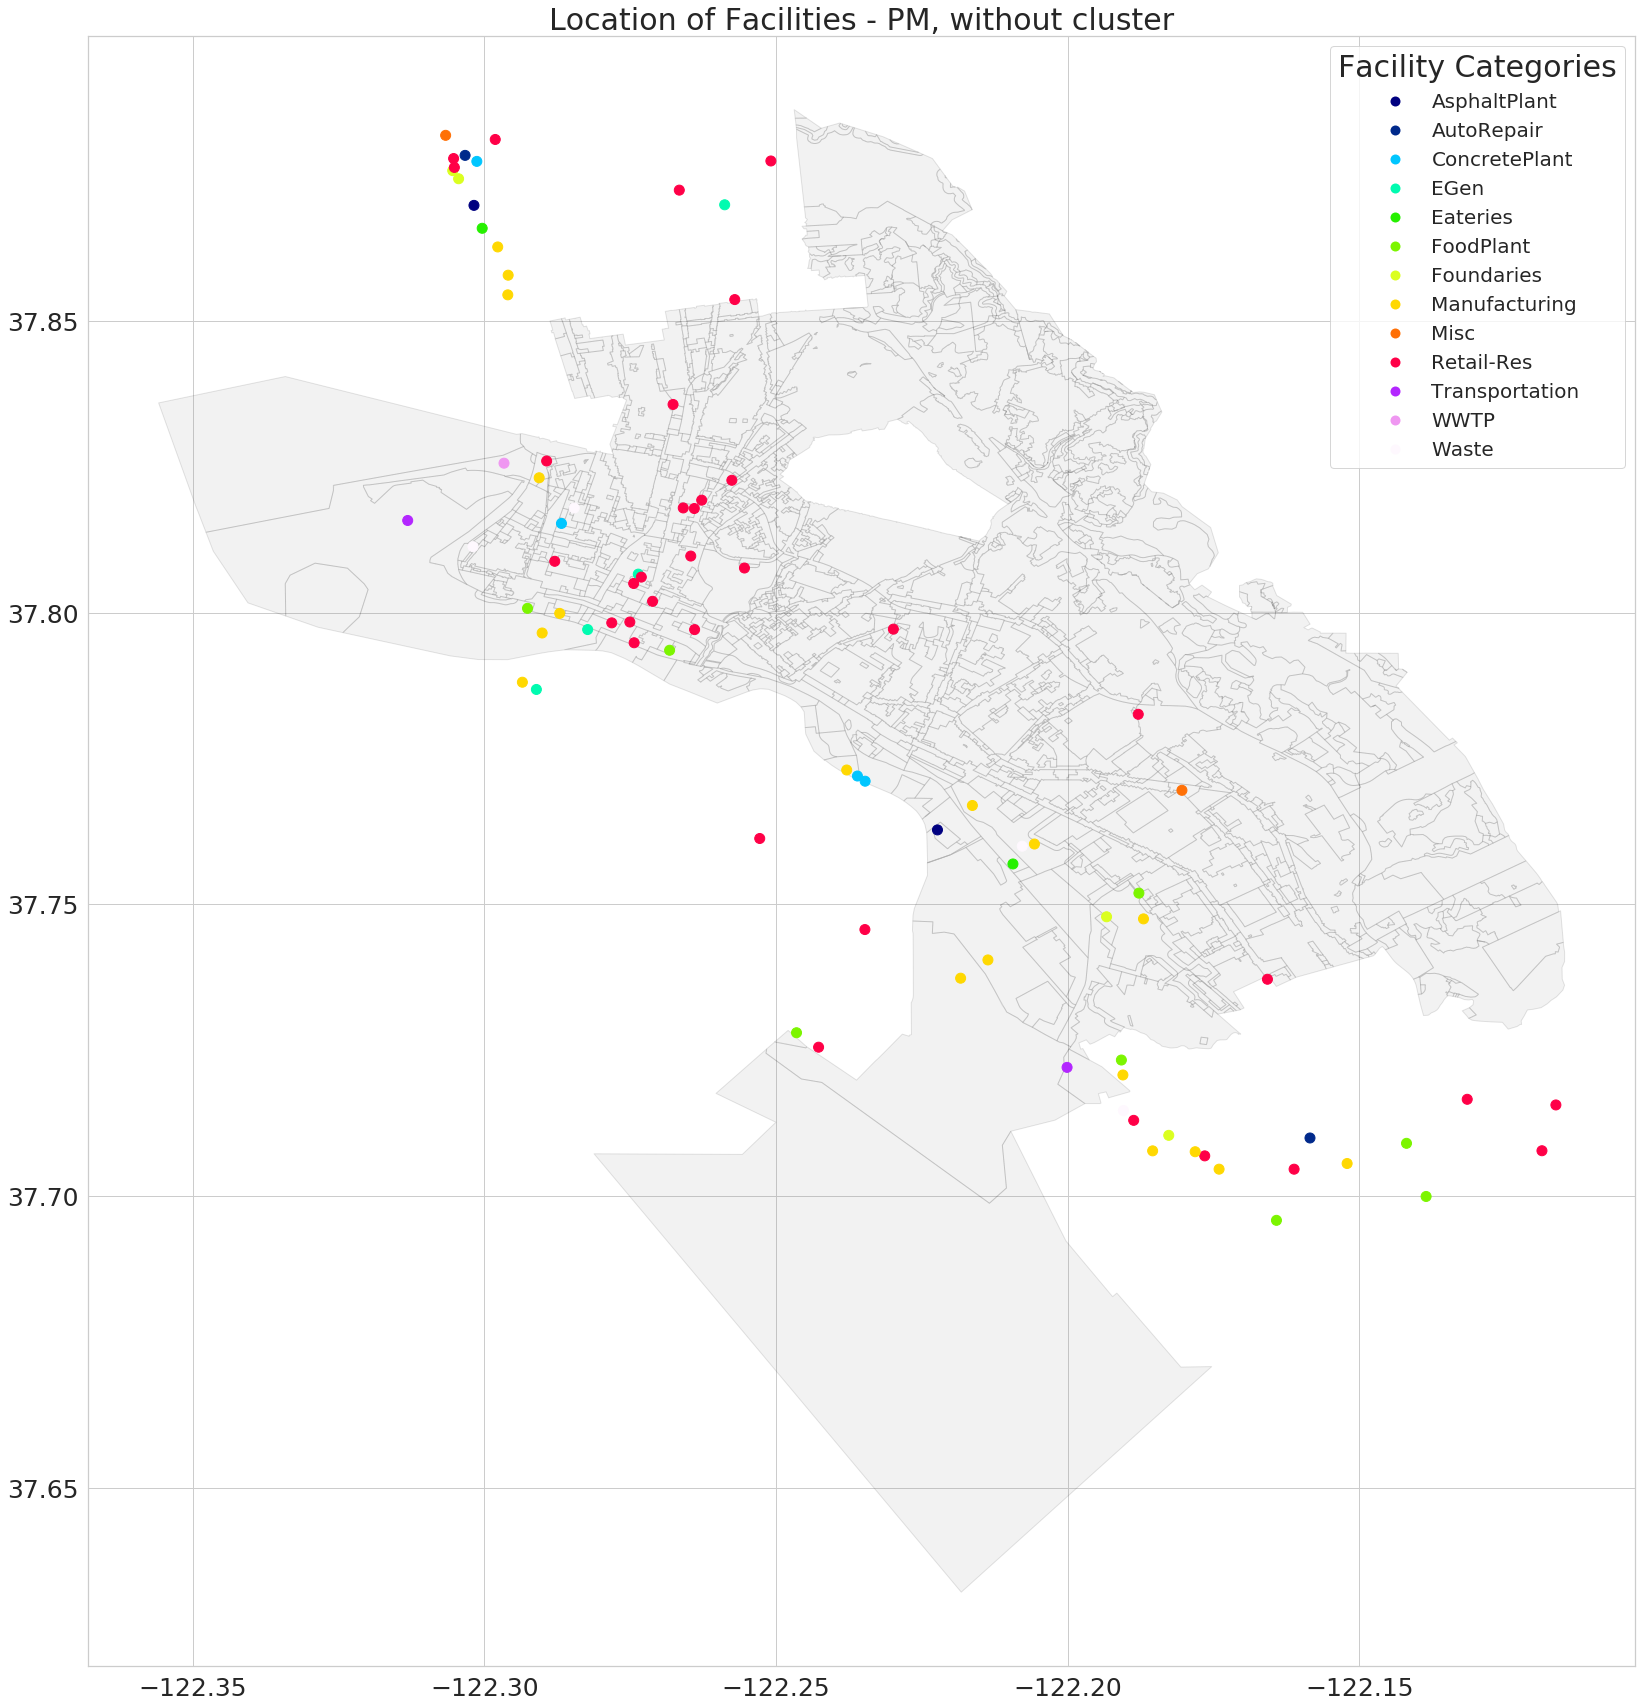

In [380]:
#### PM Plot - Facilities classified as high

fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_PM.plot(ax=ax, column = 'source-type', legend = True, markersize =100, marker = 'o', cmap = 'gist_ncar')
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':30})
ax.tick_params(labelsize=25) 
plt.title("Location of Facilities - PM, without clustering", size = 30)




plt.show()

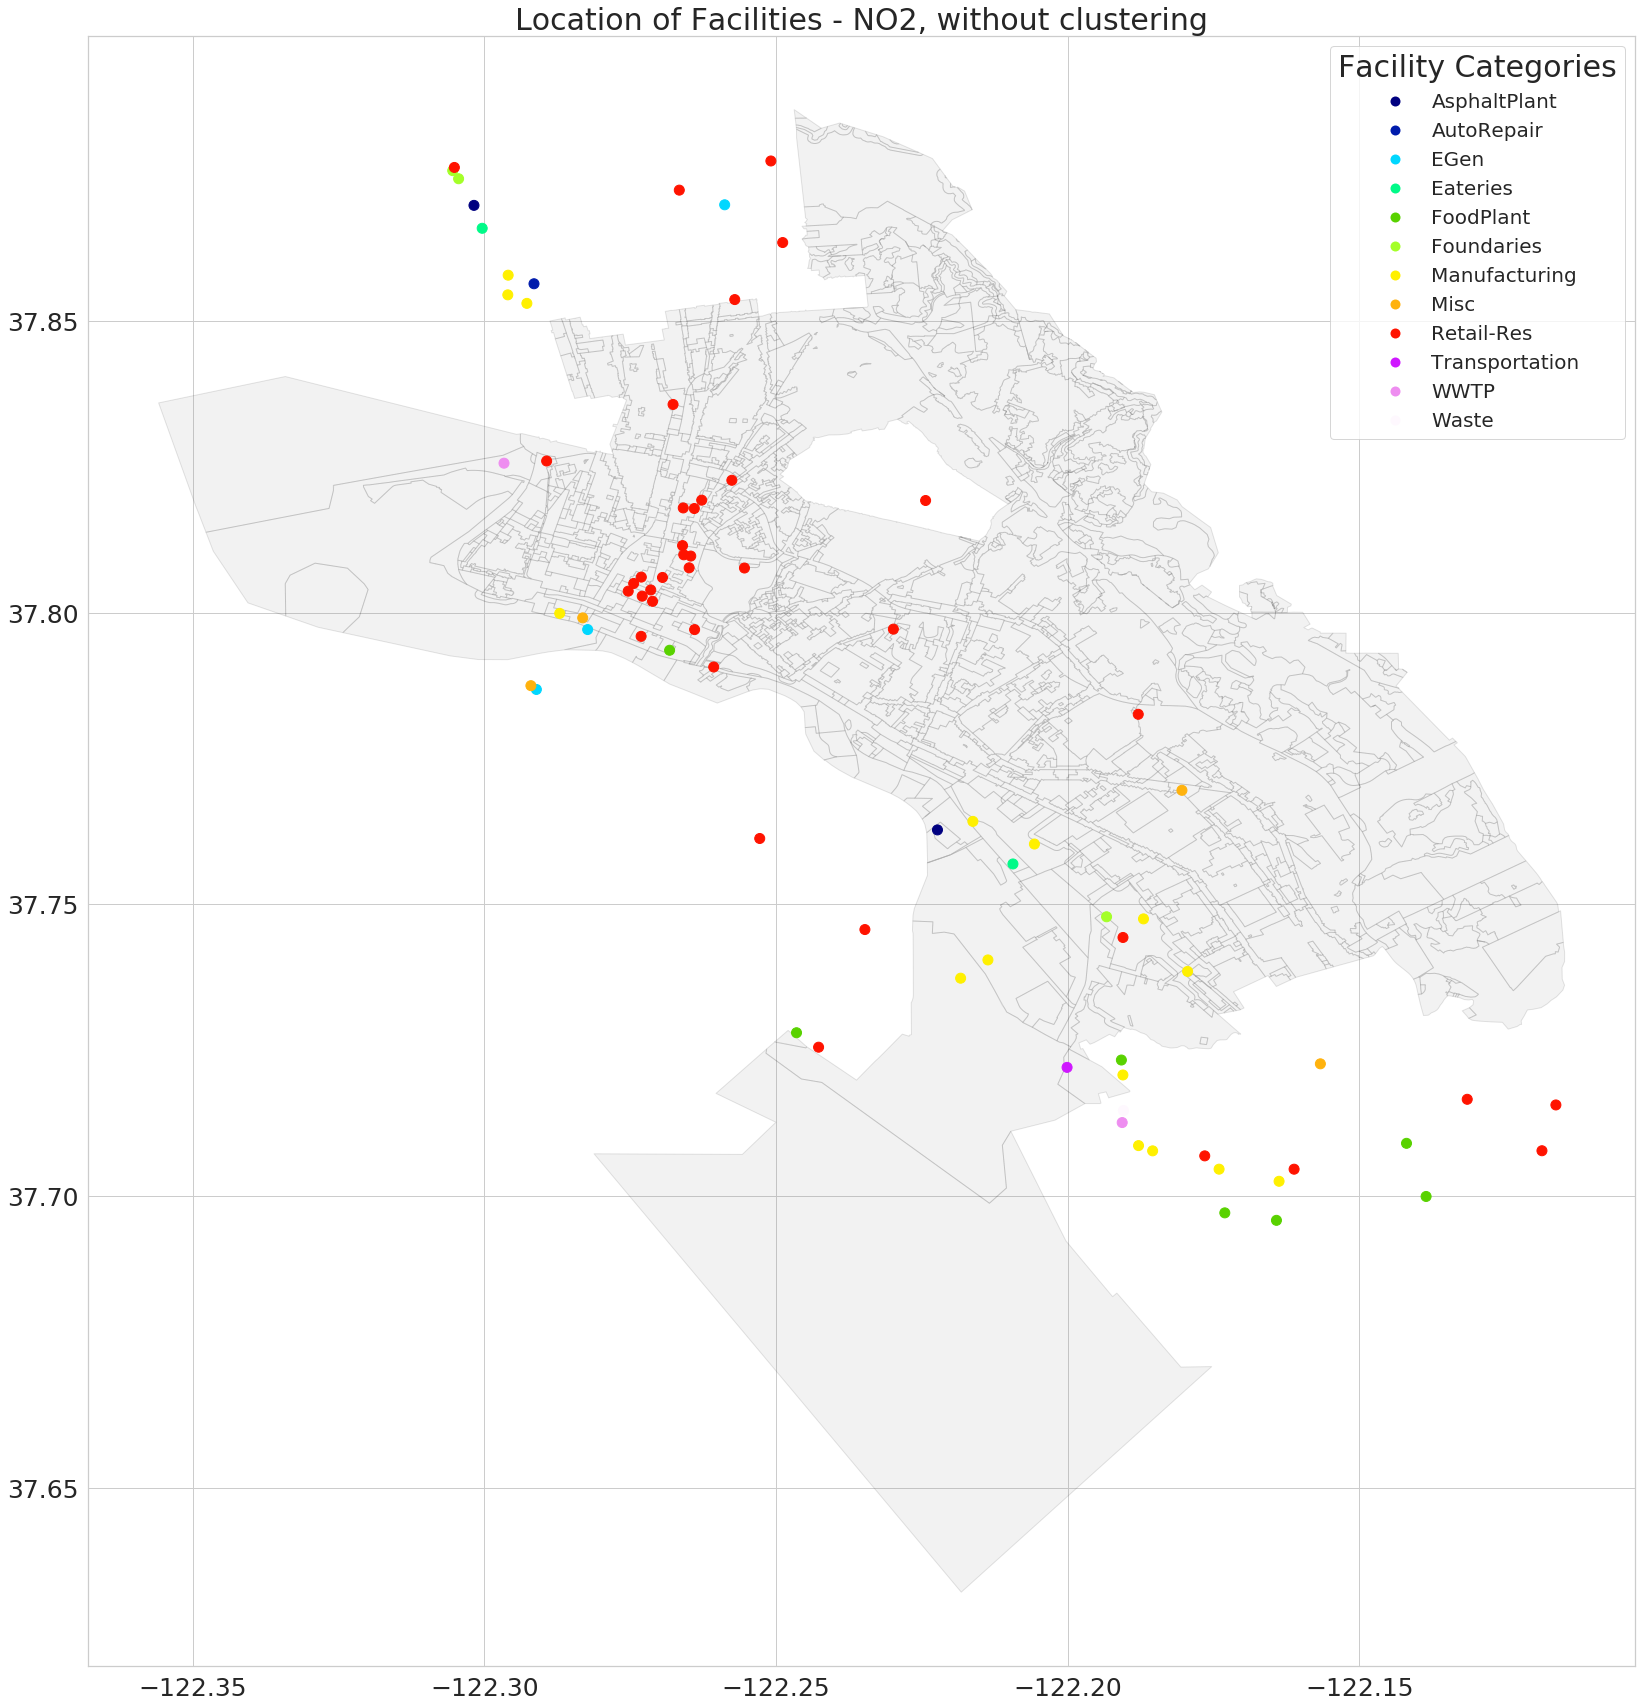

In [381]:
#### NO2 Plot - Facilities classified as high


fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_NO2.plot(ax=ax, column = 'source-type', legend = True, markersize =100, marker = 'o', cmap = 'gist_ncar')
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':30})
ax.tick_params(labelsize=25) 
plt.title("Location of Facilities - NO2, without clustering", size = 30)

plt.show()

### Display facilities on a map after clustering

In [382]:
BC_clustered_lat_lon = pd.read_csv("Data/PM_Facilities_High_Centroid.csv")
NO2_clustered_lat_lon = pd.read_csv("Data/NO2_Facilities_High_Centroid.csv")

In [383]:
### Create a geopandas dataframe for PM data with coordinate reference system as epsg4326

# Create a list of x and y coordinates to convert to a geodataframe using Facility_PM_high
geometry_facility_PM_clustered = [Point(xy) for xy in zip(BC_clustered_lat_lon['Centroid_Y'], BC_clustered_lat_lon['Centroid_X'])]

geo_df_facility_PM_clustered = gpd.GeoDataFrame(BC_clustered_lat_lon, crs = crs, geometry = geometry_facility_PM_clustered)

In [384]:
### Create a geopandas dataframe for NO2 data with coordinate reference system as epsg4326

# Create a list of x and y coordinates to convert to a geodataframe using Facility_PM_high
geometry_facility_NO2_clustered = [Point(xy) for xy in zip(NO2_clustered_lat_lon['Centroid_Y'], NO2_clustered_lat_lon['Centroid_X'])]

geo_df_facility_NO2_clustered = gpd.GeoDataFrame(NO2_clustered_lat_lon, crs = crs, geometry = geometry_facility_NO2_clustered)

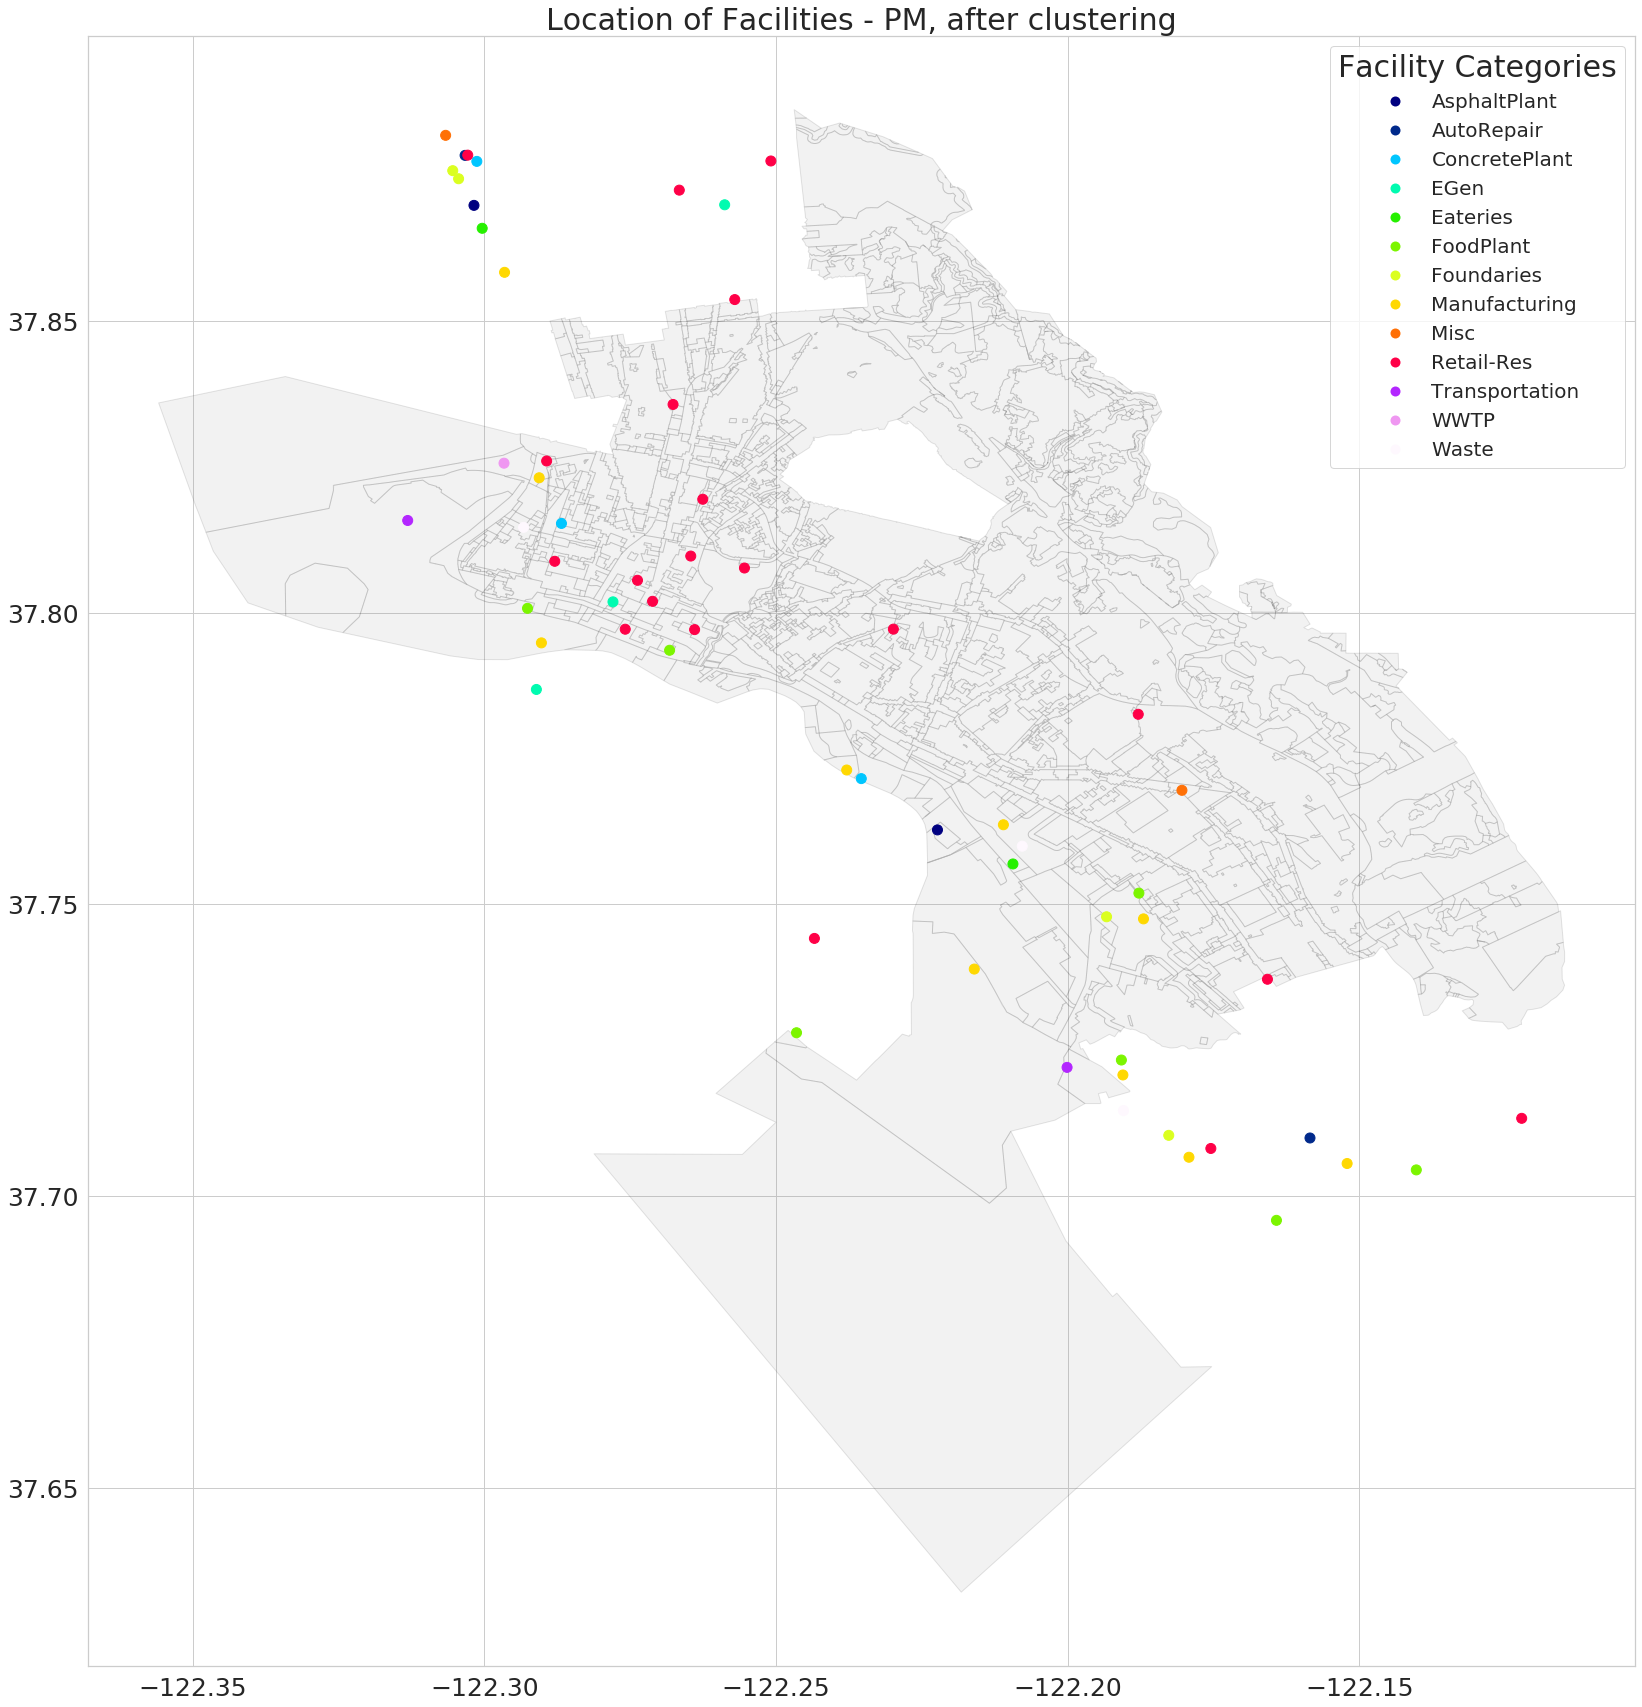

In [386]:
#### PM Plot - Facilities classified as high - Clustered

fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_PM_clustered.plot(ax=ax, column = 'source_typ', legend = True, markersize =100, marker = 'o', cmap = 'gist_ncar')
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':30})
ax.tick_params(labelsize=25) 

plt.title("Location of Facilities - PM, after clustering", size = 30)



plt.show()

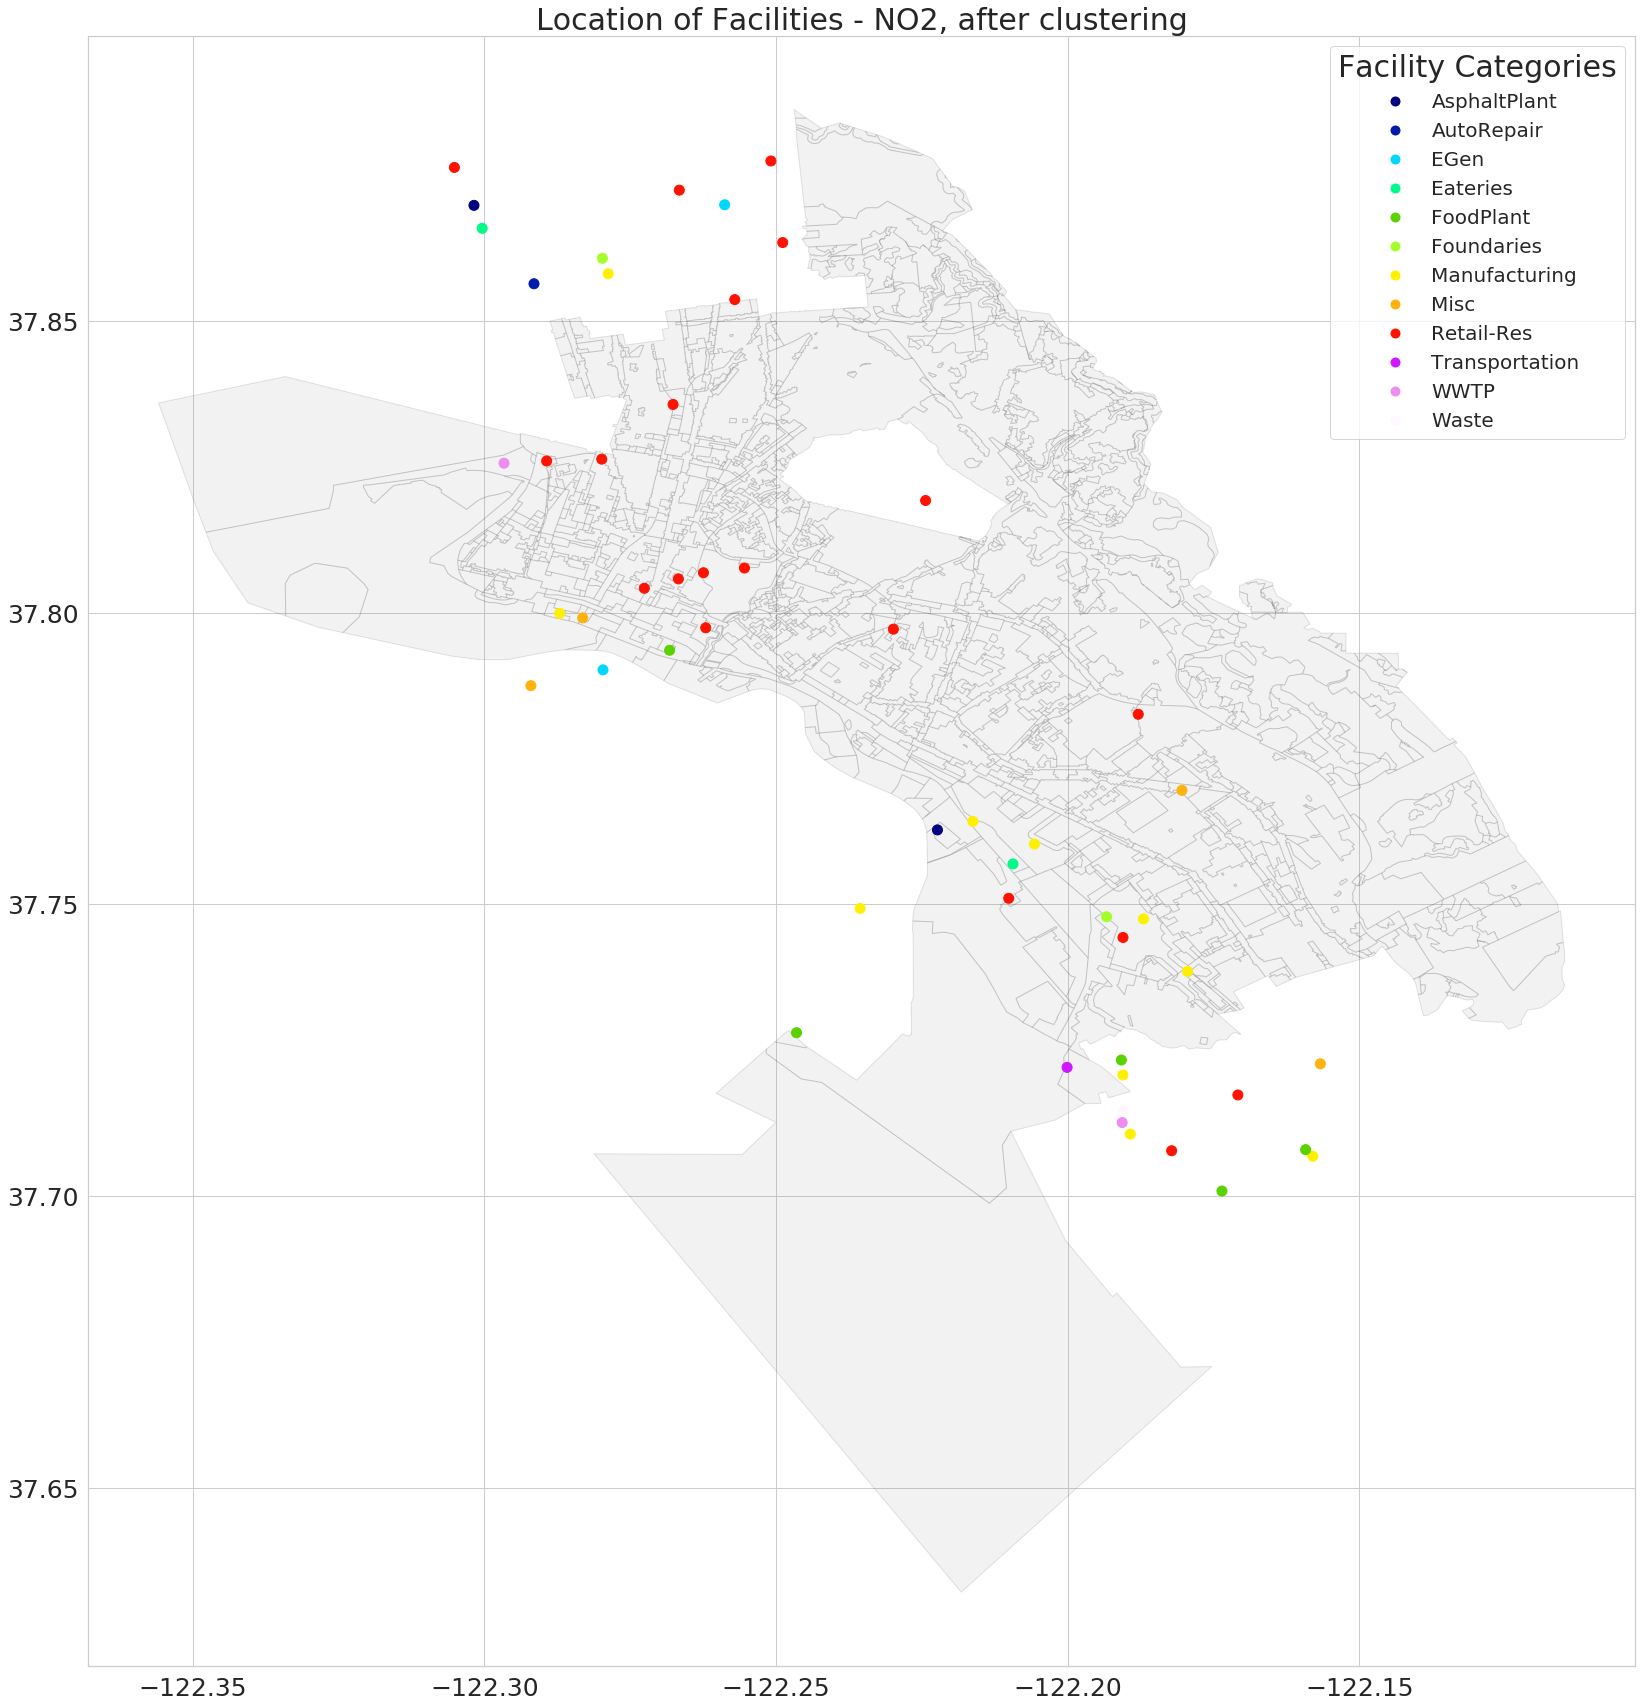

In [387]:
#### NO2 Plot - Facilities classified as high - Clustered


fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_NO2_clustered.plot(ax=ax, column = 'source-typ', legend = True, markersize =100, marker = 'o', cmap = 'gist_ncar')
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':30})
ax.tick_params(labelsize=25) 

plt.title("Location of Facilities - NO2, after clustering", size = 30)


plt.show()

<b> <font size =5> Load Input Data Frame with Clustered Points</b> </font>

In [461]:
BC_clustered = pd.read_csv("Data/BC_input_clustered.csv")
NO2_clustered = pd.read_csv("Data/NO2_input_clustered.csv")

<b> <font size =5> Test 2: Plot Heat Map of Correlation Between Features</b> </font>

In [462]:
BC_clustered.drop(columns = ['Unnamed: 0'], inplace=True)
NO2_clustered.drop(columns = ['Unnamed: 0'], inplace=True)

In [337]:
### Plot a heat map - Black Carbon
corr_BC = BC_clustered.corr()
arr_corr_BC= corr_BC.as_matrix()

module://ipykernel.pylab.backend_inline


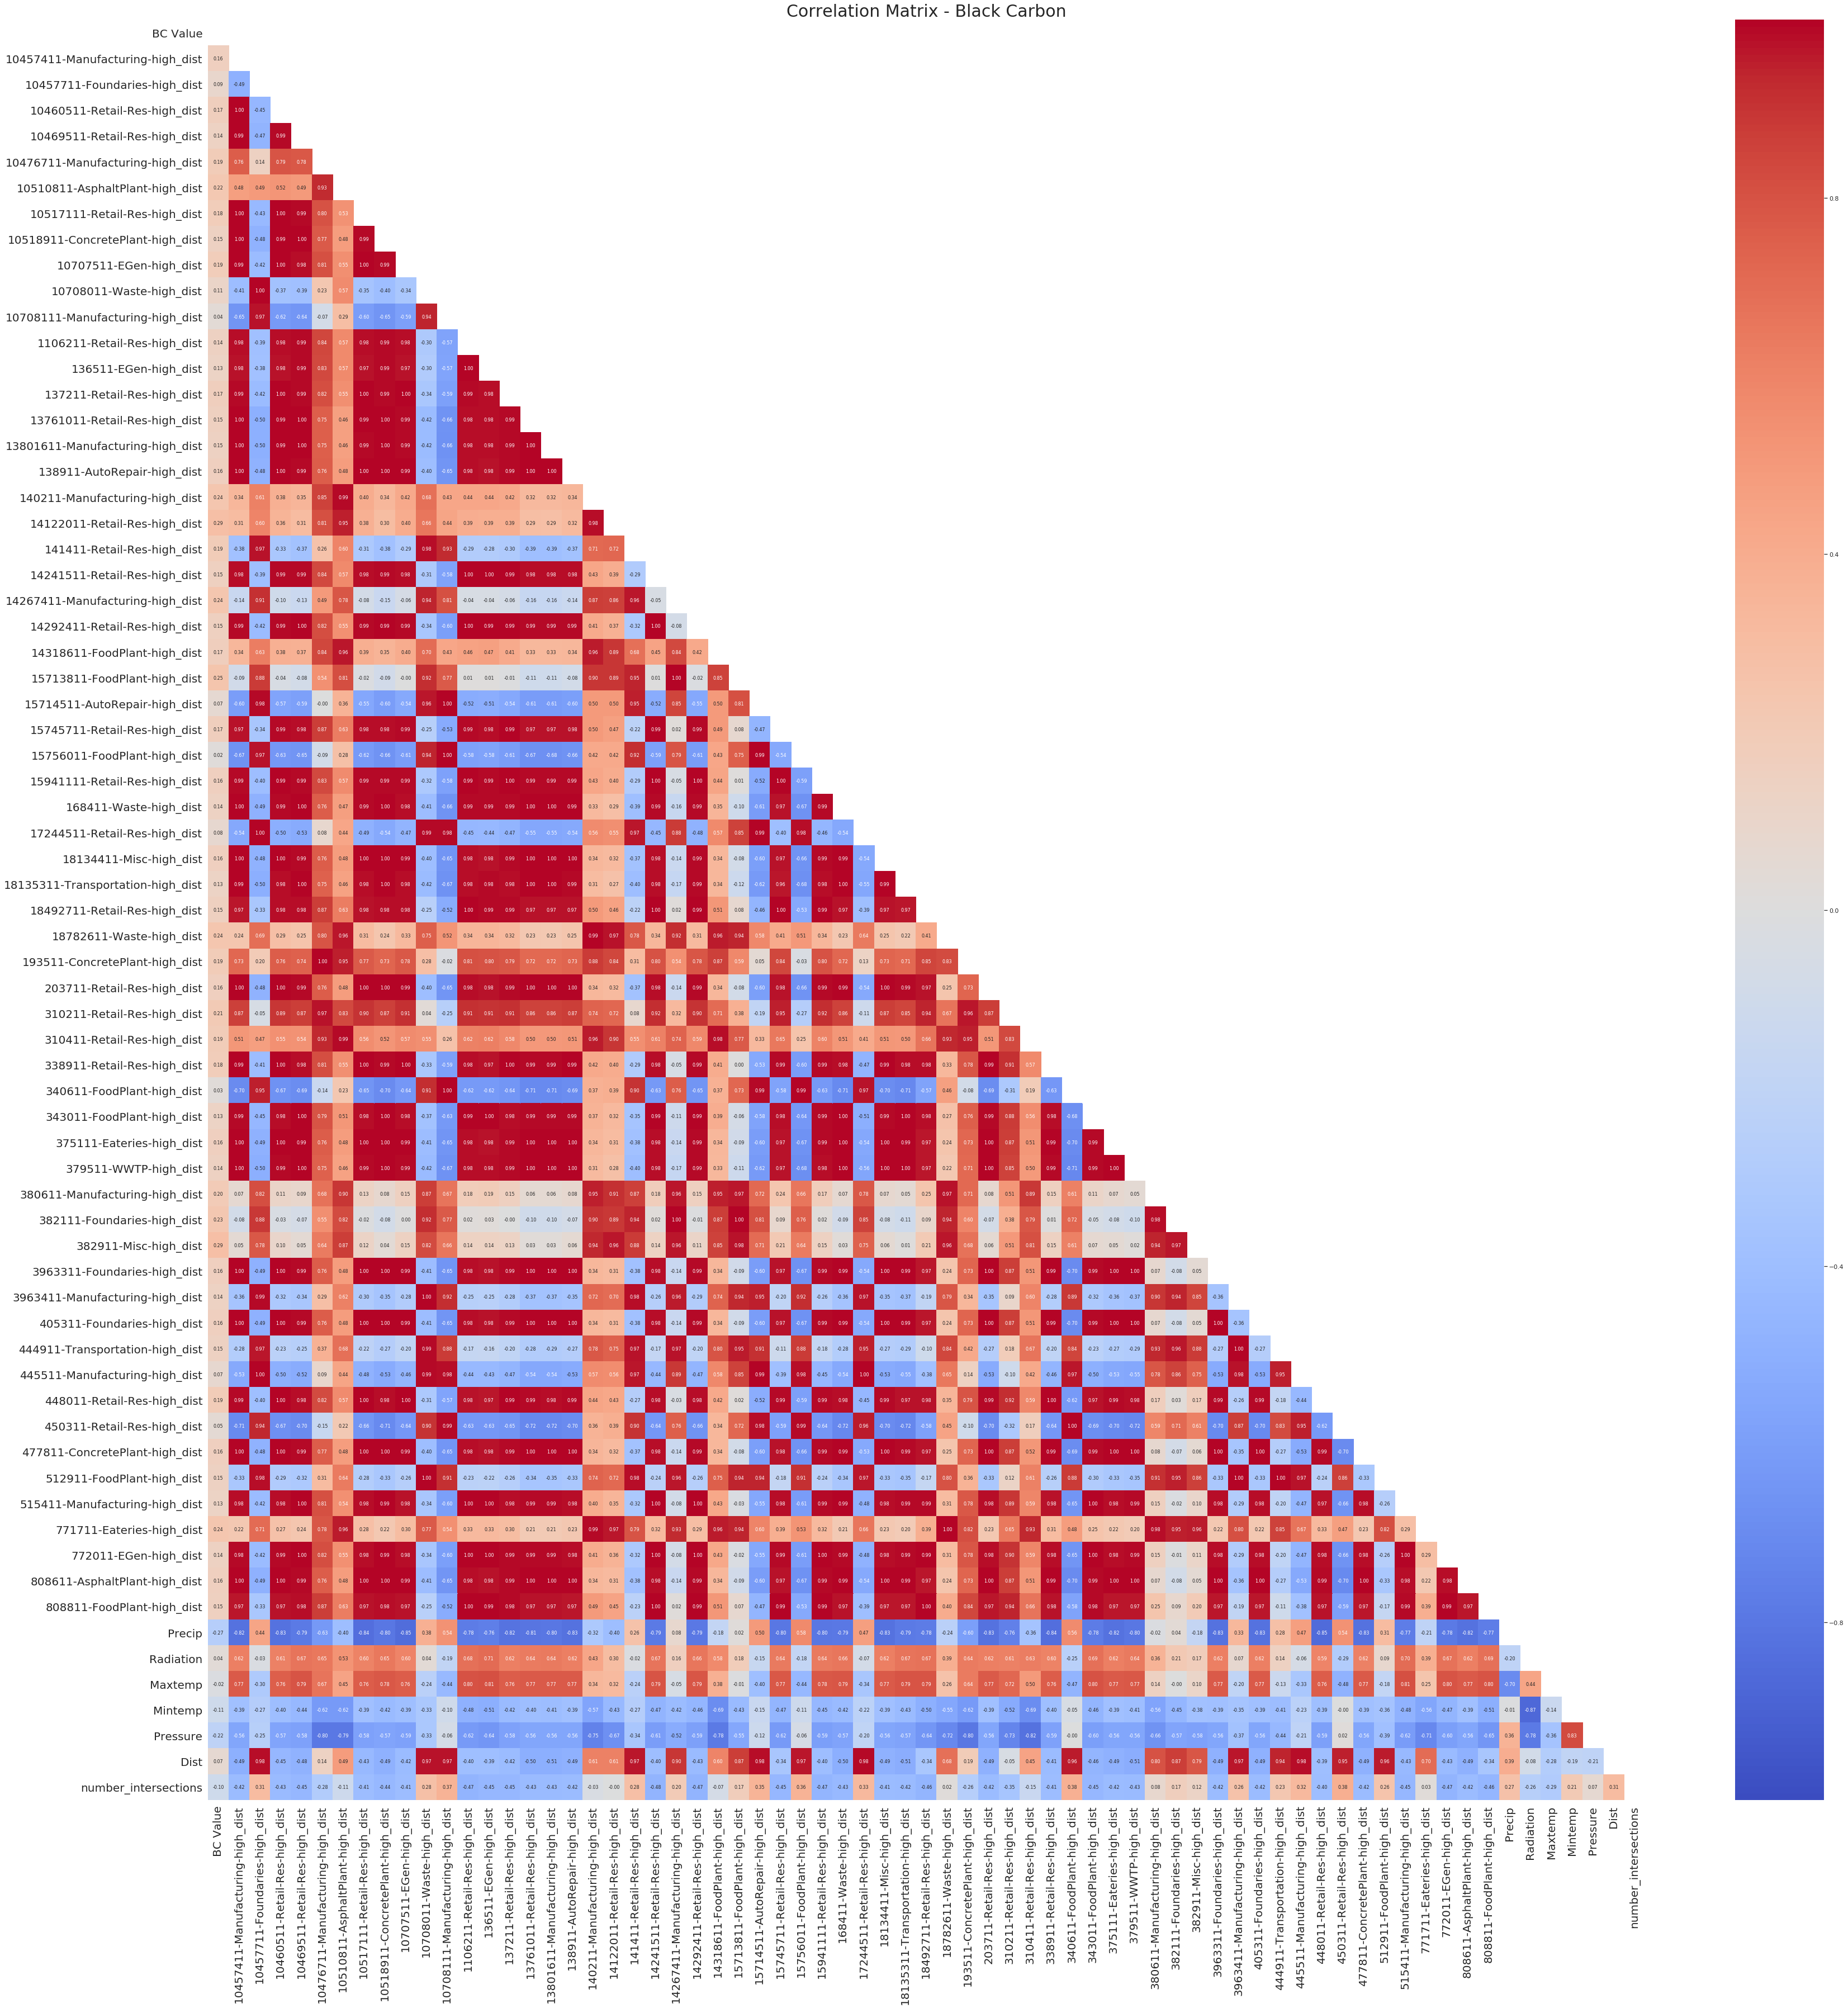

In [338]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr_BC[np.triu_indices_from(arr_corr_BC)] = np.nan

fig, ax = plt.subplots(figsize=(50, 50))

hm = sns.heatmap(arr_corr_BC, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(corr_BC.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr_BC.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(corr_BC.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - Black Carbon', fontsize  = 30)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

In [339]:
### Plot a heat map - Nitrogen Dioxide
corr_NO2 = NO2_clustered.corr()
arr_corr_NO2= corr_NO2.as_matrix()

module://ipykernel.pylab.backend_inline


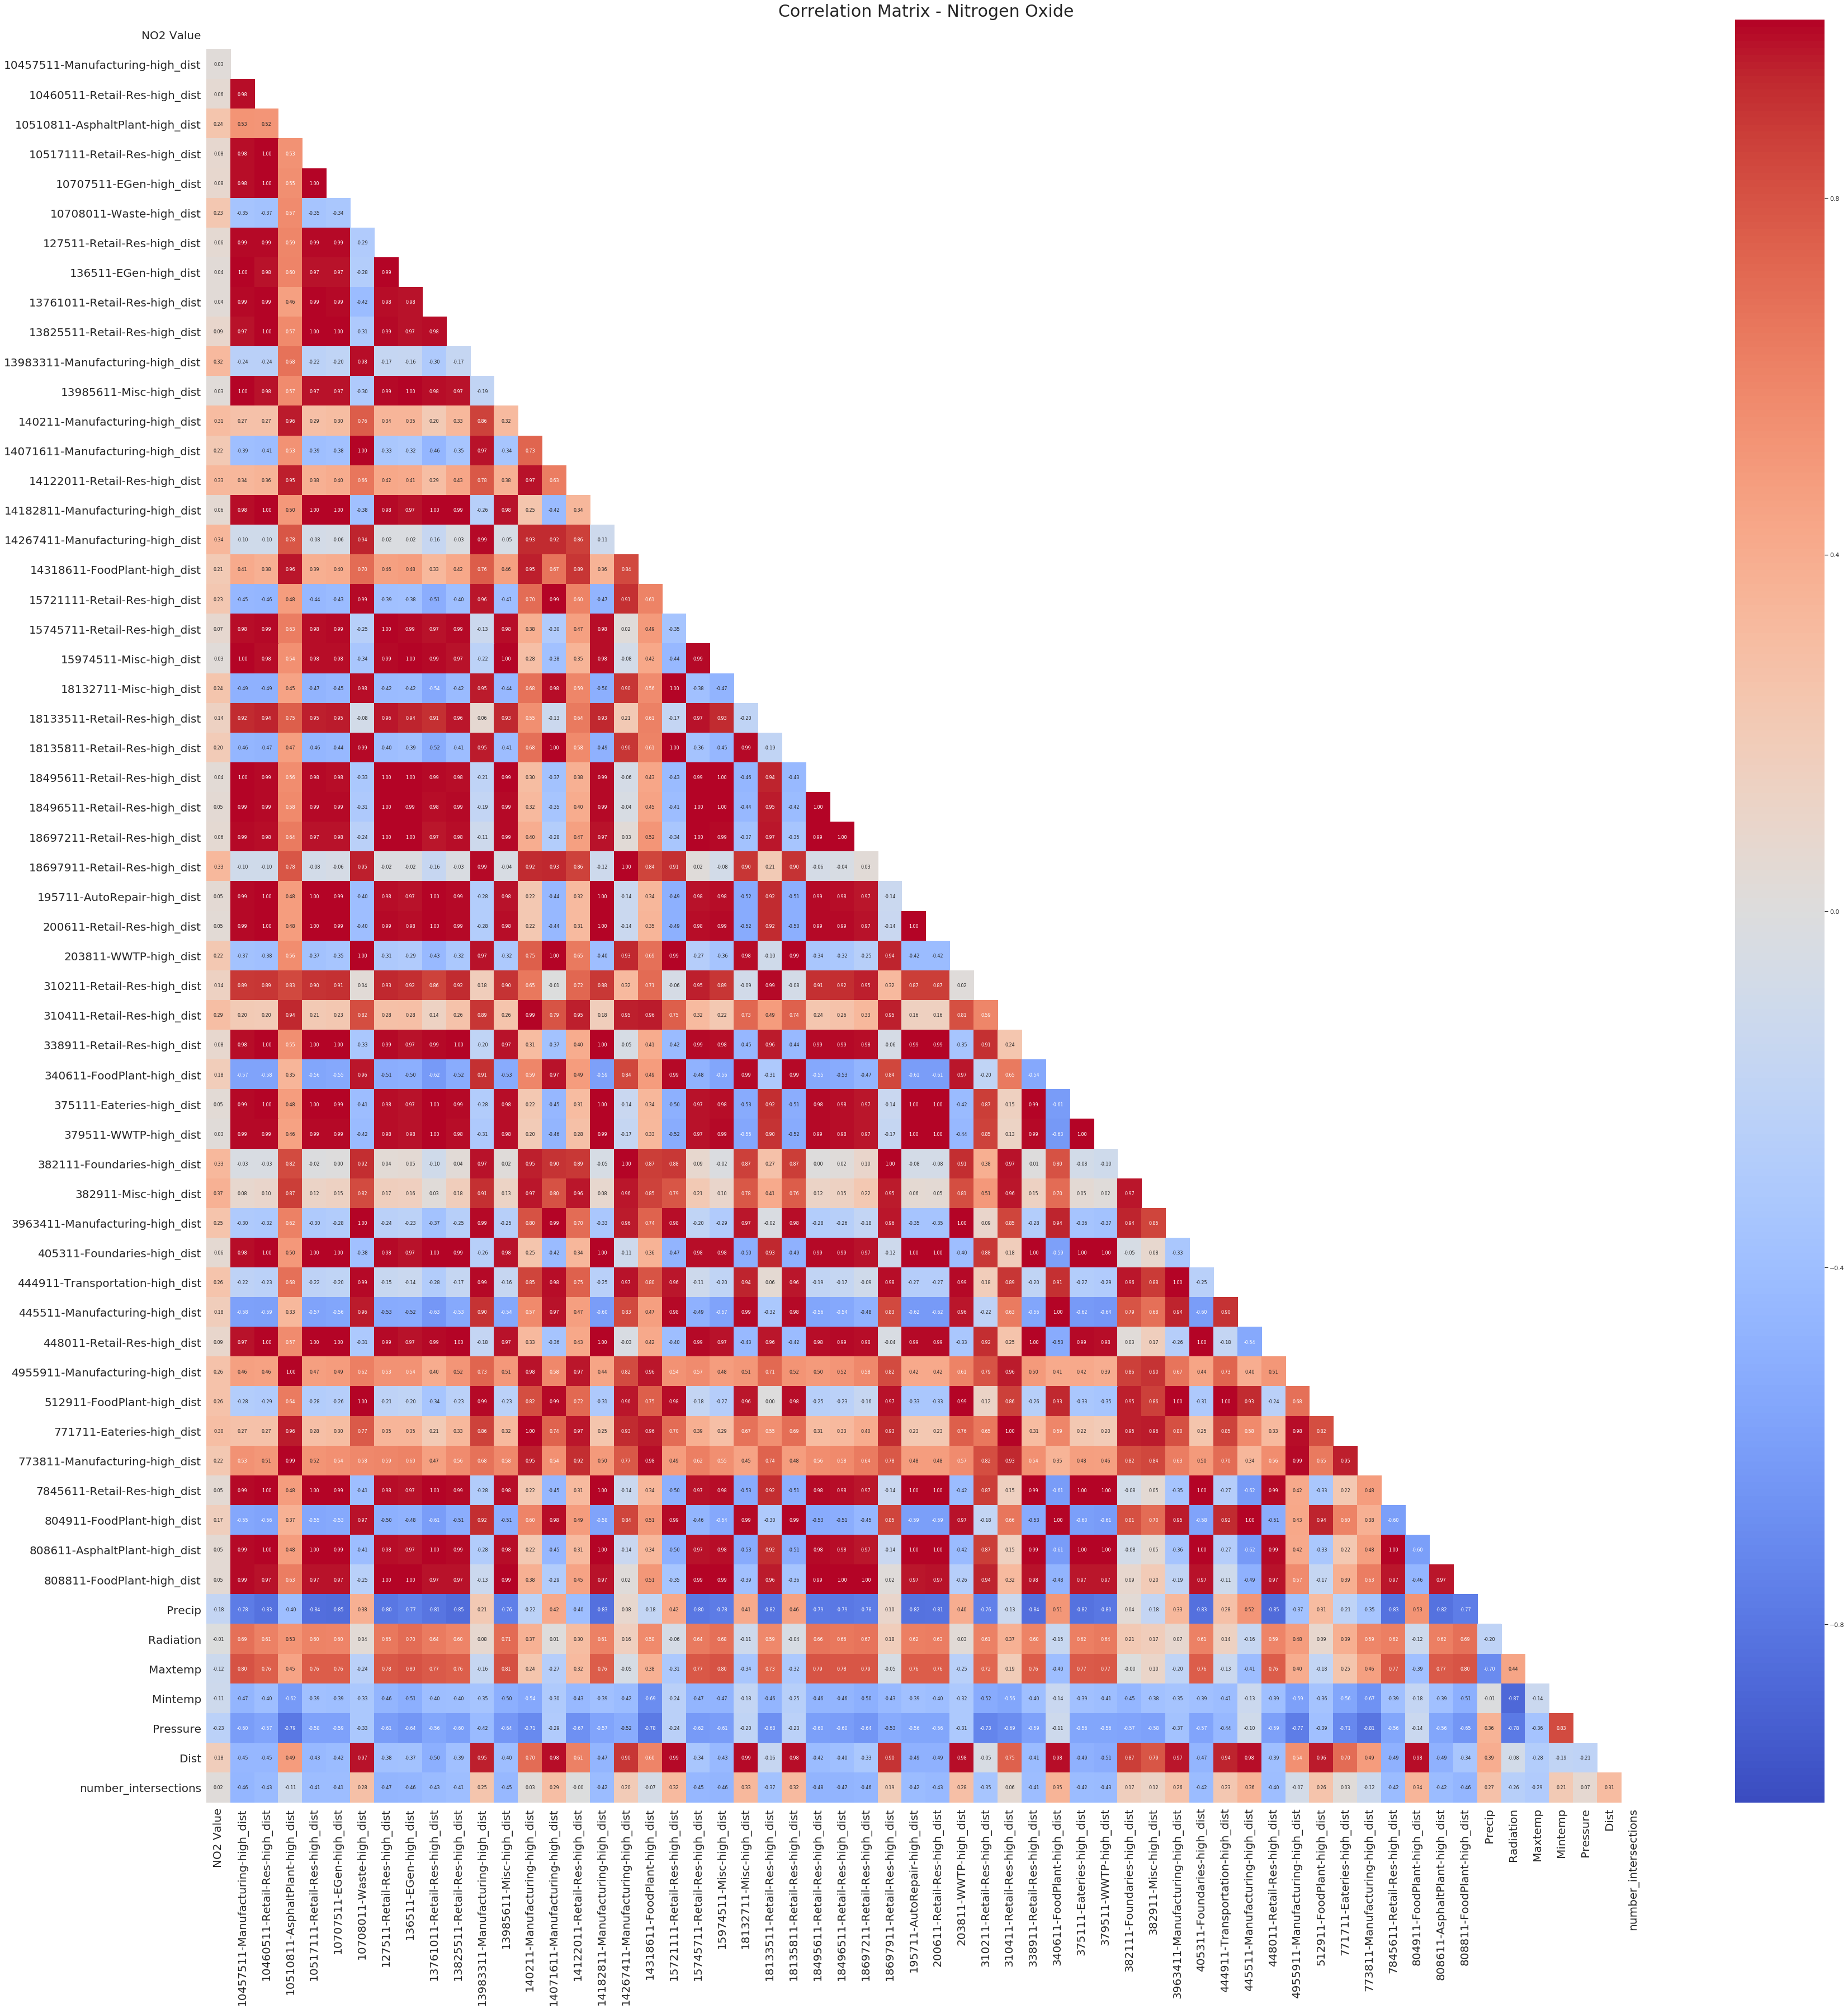

In [340]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr_NO2[np.triu_indices_from(arr_corr_NO2)] = np.nan

fig, ax = plt.subplots(figsize=(50, 50))

hm = sns.heatmap(arr_corr_NO2, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(corr_NO2.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr_NO2.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(corr_NO2.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - Nitrogen Oxide', fontsize  = 30)
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

<font size = 3> <b> Result: </b> Looking at the correlation heat map, there are a lot of features that are highly correlated. Next we identify features that have a correlation coefficient above 0.95 since having highly correlated fetures would result in multicolinearity.  </font>

<b> <font size = 5> Test 3: Identifying features that have a high correlation, with a correlation coefficient above 0.9 </b> </font>

<b> <font size = 3> Identifying highly correlation features in BC dataset </b> </font>

In [388]:
# First, create a dataframe with only the features and drop the taget variable, which is BC Value.
BC_features = BC_clustered.drop(columns = ['BC Value'])
BC_features.head()

10457411-Manufacturing-high_dist  10457711-Foundaries-high_dist  \
0                          3.833478                      10.131771   
1                          3.868312                      10.091528   
2                          3.850748                      10.103376   
3                          3.885473                      10.078866   
4                          3.832796                      10.114173   

   10460511-Retail-Res-high_dist  10469511-Retail-Res-high_dist  \
0                       3.600953                       1.896254   
1                       3.612502                       1.884551   
2                       3.601578                       1.882327   
3                       3.622568                       1.885850   
4                       3.589663                       1.878961   

   10476711-Manufacturing-high_dist  10510811-AsphaltPlant-high_dist  \
0                          5.177325                         6.260157   
1                          5.144002                         6.225561   
2                          5.151872                         6.234118   
3                          5.135194                         6.216077   
4                          5.158560                         6.241503   

   10517111-Retail-Res-high_dist  10518911-ConcretePlant-high_dist  \
0                       5.466311                          2.040220   
1                       5.493914                          2.038467   
2                       5.478097                          2.032285   
3                       5.509127                          2.043743   
4                       5.461635                          2.025006   

   10707511-EGen-high_dist  10708011-Waste-high_dist  \
0                 5.577767                  9.620051   
1                 5.602305                  9.579673   
2                 5.587334                  9.591607   
3                 5.616603                  9.566930   
4                 5.571631                  9.602495   

   10708111-Manufacturing-high_dist  1106211-Retail-Res-high_dist  \
0                         11.640505                      2.635694   
1                         11.602024                      2.610019   
2                         11.612790                      2.614031   
3                         11.590391                      2.605054   
4                         11.622449                      2.616851   

   136511-EGen-high_dist  137211-Retail-Res-high_dist  \
0               2.203323                     3.389903   
1               2.164149                     3.386504   
2               2.175306                     3.381005   
3               2.152221                     3.391025   
4               2.185464                     3.374334   

   13761011-Retail-Res-high_dist  13801611-Manufacturing-high_dist  \
0                       2.248262                          2.078224   
1                       2.261906                          2.089358   
2                       2.250246                          2.078529   
3                       2.272773                          2.099374   
4                       2.237665                          2.066748   

   138911-AutoRepair-high_dist  140211-Manufacturing-high_dist  \
0                     5.055463                        6.778812   
1                     5.094900                        6.745859   
2                     5.076528                        6.753539   
3                     5.113038                        6.737222   
4                     5.057980                        6.760019   

   14122011-Retail-Res-high_dist  141411-Retail-Res-high_dist  \
0                       7.537415                     9.818741   
1                       7.512788                     9.783986   
2                       7.516351                     9.792636   
3                       7.508184                     9.774397   
4                       7.518633                     9.800099   

   14241511-Retail-Re

In [389]:
len(BC_features)

21488

In [390]:
# Next determine the correlation matrix between all the input features
BC_features_corr = BC_features.corr()

In [391]:
# Next, identify all the features that have a correlation higher than 0.90 or lower than -0.90 indicating a strong positive or negative correlation
threshold_1 = 0.90
threshold_2 = -0.90


columns = np.full((BC_features_corr.shape[0],), True, dtype=bool)
for i in range(BC_features_corr.shape[0]):
    for j in range(i+1, BC_features_corr.shape[0]):
        if (BC_features_corr.iloc[i,j] >= threshold_1) | (BC_features_corr.iloc[i,j] <= threshold_2) :
            if columns[j]:
                columns[j] = False
selected_columns = BC_features.columns[columns]
selected_columns
#df_boston = df_boston[selected_columns]

Index(['10457411-Manufacturing-high_dist', '10457711-Foundaries-high_dist',
       '10476711-Manufacturing-high_dist', 'Precip', 'Radiation', 'Maxtemp',
       'Mintemp', 'Pressure', 'number_intersections'],
      dtype='object')

<font size = 3> <b> Result: </b> The only features that are not highly correlated in the BC dataset include ''10457411-Manufacturing-high_dist', '10476711-Manufacturing-high_dist',
       '10457711-Foundaries-high_dist', 'Precip', 'Radiation', 'Maxtemp',
       'Mintemp', 'Pressure', 'number_intersections'. Before dropping them from the model, we will first fit a linear regression model and use recurrsive feature elimination method to drop features from the model. </font>

<b> <font size = 3> Fit a linear regression model only with the varibles that are not highly correlated using OLS- BC dataset</b> </font>

In [417]:
BC_clustered.rename(columns = {'BC Value': 'BC_Value'}, inplace = True)

In [424]:
BC_clustered.rename(columns = {'10457411-Manufacturing-high_dist': 'Manuf1', '10457711-Foundaries-high_dist' : 'Foundaries',
                              '10476711-Manufacturing-high_dist': 'Manuf2'}, inplace = True)

In [426]:
m_BC = ols('BC_Value ~ Manuf1 + Foundaries + Manuf2 + Precip + Radiation + Maxtemp + Mintemp + Pressure + number_intersections ', BC_clustered).fit()
print(m_BC.summary())

                            OLS Regression Results                            
Dep. Variable:               BC_Value   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     911.6
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        00:42:40   Log-Likelihood:                -16234.
No. Observations:               21488   AIC:                         3.249e+04
Df Residuals:                   21478   BIC:                         3.257e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               73.5808 

In [428]:
print("The R2 is {}".format(m_BC.rsquared))
print("The R2 tells us that the correlation between BC and input features is pretty low. ")


The R2 is 0.2764016101338902
The R2 tells us that the correlation between BC and input features is pretty low. 


In [429]:
## Coefficient and Intercept
print("Coefficient of linear regression model is {}".format(m_BC.params[1]))
print("Intercept of linear regression model is {}".format(m_BC.params[0]))


Coefficient of linear regression model is 0.07579381078624003
Intercept of linear regression model is 73.58081434440993


Text(1.2, 8, 'R2 = 0.274')

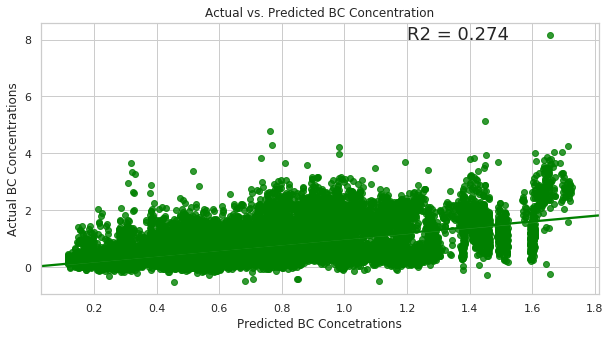

In [449]:
# Creating a plot of BC concentration vs predicted concentration using OLS
plt.figure(figsize = (10,5))
sns.regplot(m_BC.fittedvalues, BC_clustered.BC_Value, fit_reg=True, color='green')
plt.ylabel('Actual BC Concentrations')
plt.xlabel('Predicted BC Concetrations')
plt.title('Actual vs. Predicted BC Concentration')
plt.text(1.2 , 8 ,"R2 = 0.274", fontsize = 18)




<b> <font size = 3> Identifying highly correlated features in NO2 dataset </b> </font>

In [450]:
# First, create a dataframe with only the features and drop the taget variable, which is NO2 Value.
NO2_features = NO2_clustered.drop(columns = ['NO2 Value'])
NO2_features.head()

10457511-Manufacturing-high_dist  10460511-Retail-Res-high_dist  \
0                          1.995507                       3.600953   
1                          1.970443                       3.612502   
2                          1.974141                       3.601578   
3                          1.965829                       3.622568   
4                          1.976688                       3.589663   

   10510811-AsphaltPlant-high_dist  10517111-Retail-Res-high_dist  \
0                         6.260157                       5.466311   
1                         6.225561                       5.493914   
2                         6.234118                       5.478097   
3                         6.216077                       5.509127   
4                         6.241503                       5.461635   

   10707511-EGen-high_dist  10708011-Waste-high_dist  \
0                 5.577767                  9.620051   
1                 5.602305                  9.579673   
2                 5.587334                  9.591607   
3                 5.616603                  9.566930   
4                 5.571631                  9.602495   

   127511-Retail-Res-high_dist  136511-EGen-high_dist  \
0                     3.282128               2.607717   
1                     3.267003               2.574884   
2                     3.266277               2.582470   
3                     3.266724               2.566407   
4                     3.264321               2.588925   

   13761011-Retail-Res-high_dist  13825511-Retail-Res-high_dist  \
0                       2.248262                       5.611028   
1                       2.261906                       5.630476   
2                       2.250246                       5.617015   
3                       2.272773                       5.643168   
4                       2.237665                       5.602698   

   13983311-Manufacturing-high_dist  13985611-Misc-high_dist  \
0                          9.126174                 2.135228   
1                          9.090484                 2.096092   
2                          9.099646                 2.107225   
3                          9.080400                 2.084191   
4                          9.107642                 2.117360   

   140211-Manufacturing-high_dist  14071611-Manufacturing-high_dist  \
0                        7.140331                          9.853745   
1                        7.107025                          9.812993   
2                        7.114893                          9.825168   
3                        7.098205                          9.800020   
4                        7.121563                          9.836310   

   14122011-Retail-Res-high_dist  14182811-Manufacturing-high_dist  \
0                       7.537415                          4.274371   
1                       7.512788                          4.301993   
2                       7.516351                          4.286164   
3                       7.508184                          4.317225   
4                       7.518633                          4.269696   

   14267411-Manufacturing-high_dist  14318611-FoodPlant-high_dist  \
0                          8.457198                      6.846074   
1                          8.422646                      6.802082   
2                          8.431184                      6.816590   
3                          8.413170                      6.786923   
4                          8.438537                      6.830232   

   15721111-Retail-Res-high_dist  15745711-Retail-Res-high_dist  \
0                      10.335052                       3.665912   
1                      10.296658                       3.651422   
2                      10.307371                       3.650432   
3                      10.285078                       3.651394   
4                      10.316978                       3.648203   

   15974511-Misc-high_dist  18132

In [451]:
# Next determine the correlation matrix between all the input features
NO2_features_corr = NO2_features.corr()

In [452]:
# Next, identify all the features that have a correlation higher than 0.90 or lower than -0.90 indicating a strong positive or negative correlation
threshold_1 = 0.90
threshold_2 = -0.90


columns = np.full((NO2_features_corr.shape[0],), True, dtype=bool)
for i in range(NO2_features_corr.shape[0]):
    for j in range(i+1, NO2_features_corr.shape[0]):
        if (NO2_features_corr.iloc[i,j] >= threshold_1) | (NO2_features_corr.iloc[i,j] <= threshold_2) :
            if columns[j]:
                columns[j] = False
selected_columns = NO2_features.columns[columns]
selected_columns
#df_boston = df_boston[selected_columns]

Index(['10457511-Manufacturing-high_dist', '10510811-AsphaltPlant-high_dist',
       '10708011-Waste-high_dist', 'Precip', 'Radiation', 'Maxtemp', 'Mintemp',
       'Pressure', 'number_intersections'],
      dtype='object')

<font size = 3> <b> Result: </b>  The only features that are not highly correlated in the NO2 dataset include '10457511-Manufacturing-high_dist', '10708011-Waste-high_dist', '10510811-AsphaltPlant-high_dist', 
       'Precip', 'Radiation', 'Maxtemp', 'Mintemp', 'Pressure',
       'number_intersections'. Before dropping them from the model, we will first fit a linear regression model and use recurrsive feature elimination method to drop features from the model. </font>

<b> <font size = 3> Fit a linear regression model only with the varibles that are not highly correlated using OLS- NO2 dataset</b> </font>

In [463]:
NO2_clustered.rename(columns = {'NO2 Value': 'NO2_Value'}, inplace = True)

In [466]:
NO2_clustered.rename(columns = {'10457511-Manufacturing-high_dist': 'Manuf', '10708011-Waste-high_dist' : 'Waste',
                              '10510811-AsphaltPlant-high_dist': 'Asphalt'}, inplace = True)

In [467]:
m_NO2 = ols('NO2_Value ~ Manuf + Waste + Asphalt + Precip + Radiation + Maxtemp + Mintemp + Pressure + number_intersections ', NO2_clustered).fit()
print(m_NO2.summary())

                            OLS Regression Results                            
Dep. Variable:              NO2_Value   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     1042.
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        00:57:35   Log-Likelihood:                -75418.
No. Observations:               21488   AIC:                         1.509e+05
Df Residuals:                   21478   BIC:                         1.509e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1142.0642 

In [469]:
print("The R2 is {}".format(m_NO2.rsquared))
print("The R2 tells us that the correlation between NO2 and input features is pretty low. ")


The R2 is 0.3038595517009087
The R2 tells us that the correlation between NO2 and input features is pretty low. 


In [470]:
## Coefficient and Intercept
print("Coefficient of linear regression model is {}".format(m_NO2.params[1]))
print("Intercept of linear regression model is {}".format(m_NO2.params[0]))


Coefficient of linear regression model is 1.3430844200485934
Intercept of linear regression model is 1142.0641693414482


Text(25, 60, 'R2 = 0.303')

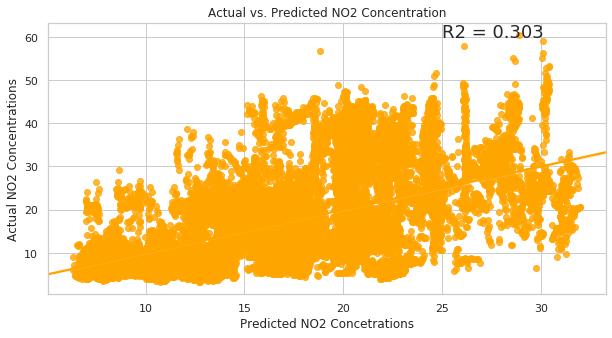

In [472]:
# Creating a plot of BC concentration vs predicted concentration using OLS
plt.figure(figsize = (10,5))
sns.regplot(m_NO2.fittedvalues, NO2_clustered.NO2_Value, fit_reg=True, color='orange')
plt.ylabel('Actual NO2 Concentrations')
plt.xlabel('Predicted NO2 Concetrations')
plt.title('Actual vs. Predicted NO2 Concentration')
plt.text(25 , 60 ,"R2 = 0.303", fontsize = 18)




<b> <font size = 5> Test 4: Recursive Feature Elimination </b> </font>

<font size = 4> <b> Performing a simple for a linear model without cross validation, using all the features in the model - BC dataset
</b> </font>

In [405]:
#Create a list containing all the features in the model
nof_list=np.arange(1,45)            

#Set the model score with highest value to be zero
high_score=0

#Create a variable to store the optimum features and a list of scores
n_var=0           
score_list =[]


#Create the dataframe
X_BC = BC_features
y_BC = BC_clustered['BC Value']


for n in range(len(nof_list)):
    #Create a test-train split for each value of 'n'
    X_train, X_test, y_train, y_test = train_test_split(X_BC,y_BC, test_size = 0.3, random_state = 0)
    
    #Instantiate a Linear Regression Model
    model = LinearRegression()
    
    #Initialize a Recursive Feature Elimination model with linear regression and 'n' features
    rfe = RFE(model,nof_list[n])
    
    #Transform training data using RFE
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    
    #Transform test data using RFE
    X_test_rfe = rfe.transform(X_test)
    
    #Fit the model using training data
    model.fit(X_train_rfe,y_train)
    
    #Calculate model score for test data
    score = model.score(X_test_rfe,y_test)
    
    #Append score to list 
    score_list.append(score)
    
    #Determine if score is highest
    if(score>high_score):
        high_score = score
        n_var = nof_list[n]

        
print("Optimum number of features: %d" %n_var)
print("Score with %d features: %f" % (n_var, high_score))






Optimum number of features: 44
Score with 44 features: 0.572223


In [406]:
len(BC_features.columns)

68

<font size = 3> <b> Determining the final features that from the RFE model
</b> </font>

In [408]:
cols = list(X_BC.columns)

#Instantiate Linear Regression Model
model = LinearRegression()

#Transforming data using RFE and nof features
rfe = RFE(model, n_var)           


#Fitting the data to model
X_rfe = rfe.fit_transform(X_BC,y_BC)  

model.fit(X_rfe,y_BC)              

#Return an array containing True and False, where True indicates a relevant feature and False indicates irrelevant feature.
temp_support = pd.Series(rfe.support_,index = cols)
temp_ranking= pd.Series(rfe.ranking_, index = cols)

selected_features_rfe = temp_support[temp_support==True].index
feature_ranking_rfe = temp_ranking[temp_ranking>0]
print(feature_ranking_rfe)


10457411-Manufacturing-high_dist      1
10457711-Foundaries-high_dist         1
10460511-Retail-Res-high_dist         1
10469511-Retail-Res-high_dist         1
10476711-Manufacturing-high_dist      1
10510811-AsphaltPlant-high_dist       1
10517111-Retail-Res-high_dist         1
10518911-ConcretePlant-high_dist      1
10707511-EGen-high_dist               1
10708011-Waste-high_dist              1
10708111-Manufacturing-high_dist      1
1106211-Retail-Res-high_dist          1
136511-EGen-high_dist                 1
137211-Retail-Res-high_dist           1
13761011-Retail-Res-high_dist         5
13801611-Manufacturing-high_dist      1
138911-AutoRepair-high_dist           1
140211-Manufacturing-high_dist        1
14122011-Retail-Res-high_dist         6
141411-Retail-Res-high_dist          11
14241511-Retail-Res-high_dist         2
14267411-Manufacturing-high_dist     15
14292411-Retail-Res-high_dist         3
14318611-FoodPlant-high_dist          1
15713811-FoodPlant-high_dist          7


<font size = 3> The RFE ranking algorithm returns a rank of 1 if the feature is important and a value greater than 1 if the feature is not imporant. The model score with 44 features is 0.57, which is pretty low.  </font>

<font size = 4> <b> Performing a simple for a linear model without cross validation, using all the features in the model - NO2 dataset
</b> </font>

In [415]:
#Create a list containing all the features in the model
nof_list=np.arange(1,45)            

#Set the model score with highest value to be zero
high_score=0

#Create a variable to store the optimum features and a list of scores
n_var=0           
score_list =[]


#Create the dataframe
X_NO2 = NO2_features
y_NO2 = NO2_clustered['NO2 Value']


for n in range(len(nof_list)):
    #Create a test-train split for each value of 'n'
    X_train, X_test, y_train, y_test = train_test_split(X_NO2,y_NO2, test_size = 0.3, random_state = 0)
    
    #Instantiate a Linear Regression Model
    model = LinearRegression()
    
    #Initialize a Recursive Feature Elimination model with linear regression and 'n' features
    rfe = RFE(model,nof_list[n])
    
    #Transform training data using RFE
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    
    #Transform test data using RFE
    X_test_rfe = rfe.transform(X_test)
    
    #Fit the model using training data
    model.fit(X_train_rfe,y_train)
    
    #Calculate model score for test data
    score = model.score(X_test_rfe,y_test)
    
    #Append score to list 
    score_list.append(score)
    
    #Determine if score is highest
    if(score>high_score):
        high_score = score
        n_var = nof_list[n]

        
print("Optimum number of features: %d" %n_var)
print("Score with %d features: %f" % (n_var, high_score))






Optimum number of features: 44
Score with 44 features: 0.633731


<font size = 3> <b> Determining the final features that from the RFE model
</b> </font>

In [416]:
cols = list(X_NO2.columns)

#Instantiate Linear Regression Model
model = LinearRegression()

#Transforming data using RFE and nof features
rfe = RFE(model, n_var)           


#Fitting the data to model
X_rfe = rfe.fit_transform(X_NO2,y_NO2)  

model.fit(X_rfe,y_NO2)              

#Return an array containing True and False, where True indicates a relevant feature and False indicates irrelevant feature.
temp_support = pd.Series(rfe.support_,index = cols)
temp_ranking= pd.Series(rfe.ranking_, index = cols)

selected_features_rfe = temp_support[temp_support==True].index
feature_ranking_rfe = temp_ranking[temp_ranking>0]
print(feature_ranking_rfe)


10457511-Manufacturing-high_dist     1
10460511-Retail-Res-high_dist        1
10510811-AsphaltPlant-high_dist      1
10517111-Retail-Res-high_dist        1
10707511-EGen-high_dist              1
10708011-Waste-high_dist             1
127511-Retail-Res-high_dist          1
136511-EGen-high_dist                1
13761011-Retail-Res-high_dist        4
13825511-Retail-Res-high_dist        1
13983311-Manufacturing-high_dist     7
13985611-Misc-high_dist              1
140211-Manufacturing-high_dist       1
14071611-Manufacturing-high_dist     1
14122011-Retail-Res-high_dist        9
14182811-Manufacturing-high_dist     1
14267411-Manufacturing-high_dist     6
14318611-FoodPlant-high_dist         1
15721111-Retail-Res-high_dist        1
15745711-Retail-Res-high_dist        1
15974511-Misc-high_dist              1
18132711-Misc-high_dist              1
18133511-Retail-Res-high_dist        1
18135811-Retail-Res-high_dist        1
18495611-Retail-Res-high_dist        1
18496511-Retail-Res-high_

<font size = 3> The RFE ranking algorithm returns a rank of 1 if the feature is important and a value greater than 1 if the feature is not imporant. Here we see that '382911-Misc-high_dist  has a ranking greater than 1, indicating that this feature are not relevant for the model predicting. The model score with 58 features is 0.58, which is pretty low.  </font>

<font size = 3> <b> Result: </b> The Recursive Feature Elimiation method gave us an idea of which features are relavant for the model prediction, and the model score for such a fit. The RFE method works by recursively removing attributes and building a model on those attributes that remain. The RFE method is a Wrapper method to determine features and is more computationally intensive than the filter method where we select features by just looking at the correlation between variables. However, this method does not give us any insights into how important each feature is i.e. is does not assign weights to features, and training a machine learning model with > 60 features can be computationally intensitve </font>

<b> <font size = 5> Test 5: Embdedded Method: Lasso Regularization </b> </font>

<font size = 3> In this method,we do feature selection using Lasso Regularization. In this method, the lasso regularization will penalize a feature's coefficient by making it 0, if a feature is irrelevant. In this case, all features with coefficient = 0 can be removed from the model. </font>

<b> <font size = 4> Lasso regularization for BC dataset </font> </b>

In [360]:
#Instantiate a Lasso Regularization model
reg = LassoCV()

#Fit the model to BC X and y
reg.fit(X_BC, y_BC)

# Lasso Scores
print("Best alpha using LassoCV: %f" % reg.alpha_)
print("Best score using LassoCV: %f" %reg.score(X_BC,y_BC))

#Estimate model coefficients. Coefficient of zero indicates that feature can be dropped
coef = pd.Series(reg.coef_, index = X_BC.columns)

Best alpha using LassoCV: 0.784248
Best score using LassoCV: 0.000000


In [361]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 0 variables and eliminated the other 68 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model for BC Dataset')

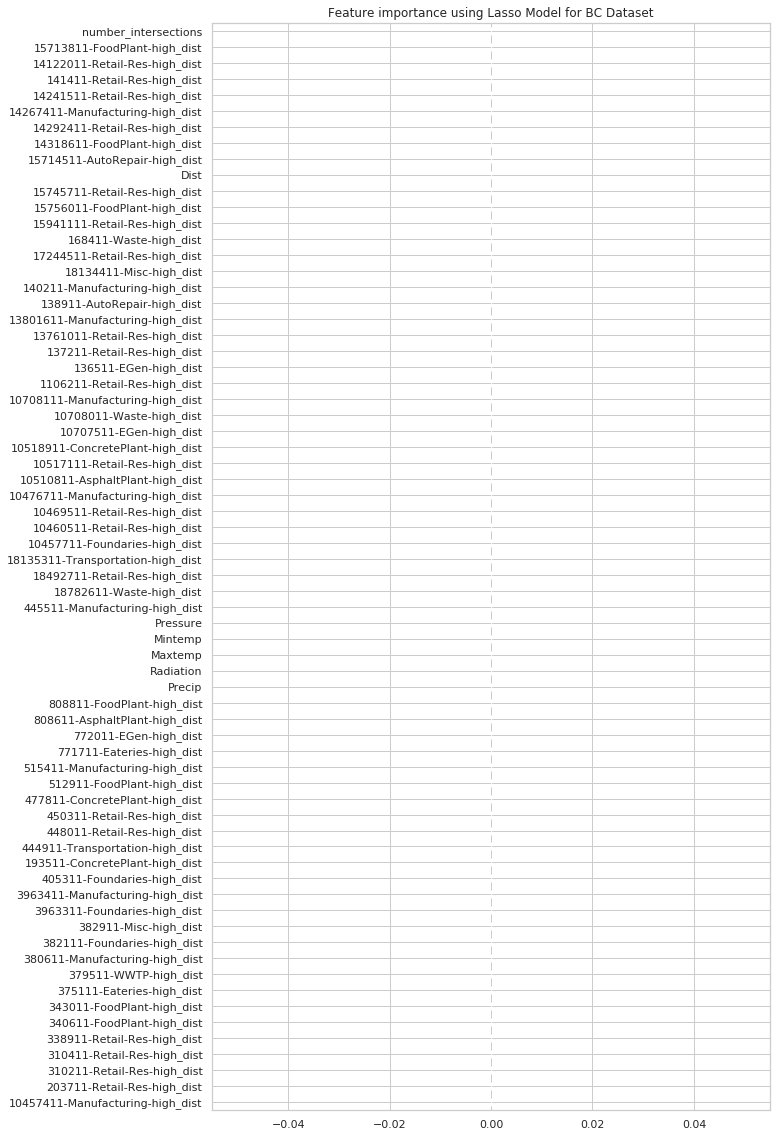

In [362]:
#Display feature importance using Lasso model

#Sort the features
imp_coef = coef.sort_values()

# Plot feature importance in  bar graph
plt.figure(figsize = (10,20))
imp_coef.plot(kind = "barh", color='green')
plt.title("Feature importance using Lasso Model for BC Dataset")

<b> <font size = 4> Lasso regularization for NO2 dataset </font> </b>

In [363]:
#Instantiate a Lasso Regularization model
reg = LassoCV()

#Fit the model to NO2 X and y
reg.fit(X_NO2, y_NO2)

# Lasso Scores
print("Best alpha using LassoCV: %f" % reg.alpha_)
print("Best score using LassoCV: %f" %reg.score(X_NO2,y_NO2))

#Estimate model coefficients. Coefficient of zero indicates that feature can be dropped
coef = pd.Series(reg.coef_, index = X_NO2.columns)

Best alpha using LassoCV: 0.163231
Best score using LassoCV: 0.514277


In [364]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 41 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model for NO2 Dataset')

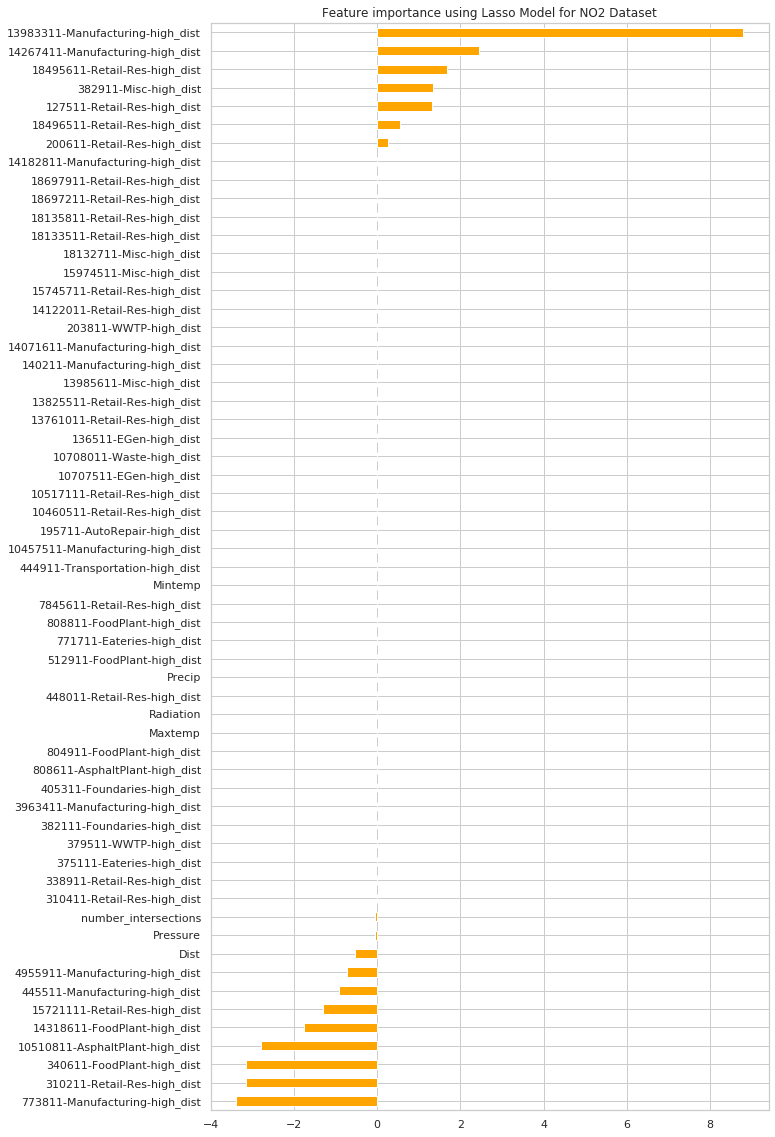

In [365]:
#Display feature importance using Lasso model

#Sort the features
imp_coef = coef.sort_values()

# Plot feature importance in  bar graph
plt.figure(figsize = (10,20))
imp_coef.plot(kind = "barh", color='orange')
plt.title("Feature importance using Lasso Model for NO2 Dataset")

#### References
##### https://etav.github.io/python/vif_factor_python.html

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b